In [70]:
import random

import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import tensorflow as tf
from tensorflow import keras as k
import sounddevice as sd
import uuid
import json
import math
from time import sleep
from PIL import Image
import librosa


In [29]:
def record(record_number = 10, count = 0, fs = 44100, duration = 2, meta_data_file = 'data/sound/meta.txt', label = 'one',mode='w'):

    meta_data = {}

    f = open(meta_data_file, mode=mode)

    #collect n number of samples
    for i in range (record_number):
        print ("Recording in 2...")
        sleep(1)
        print ("Recording in 1...")
        sleep(1)
        print ("Recording...")
        f_name = str(count)

        meta_data['id'] = uuid.uuid4().hex
        meta_data['sampling_rate'] = fs
        meta_data['duration'] = duration
        meta_data['file_name'] = str(count) + '.npy'
        meta_data['label'] = label

        #sample data from mic
        val = sd.rec(frames=fs*duration, samplerate=fs, channels=1)
        sd.wait()

        # transform obj to string
        meta_json_data = json.dumps(meta_data)
        f.write(meta_json_data + '\n')


        np.save('data/sound/'+f_name+'.npy',val)

        count += 1
        print ("Recording...Done")
        print('meta info:', meta_data)

    f.close()
    print ("Recording...Done")

In [5]:
def data_loader(file_name):
    f = open(file_name,'r')

    data = []
    lines = f.readlines()

    for l in lines:
        obj_data = json.loads(l)
        data.append(obj_data)

    f.close()
    return data

In [36]:
# helper from integer to categorical
def int2cat(int_label, nr_outputs=3):

    #[0,0,0]
    arr = np.zeros(nr_outputs)
    arr[int(int_label)] = 1

    return arr

In [43]:
def data2fftimge(data, desired_size=(227,227)):
    _,_,_,img = plt.specgram(data.flatten(),NFFT=256,Fs=44100,scale_by_freq=False, noverlap=64)

    img_2d = img.make_image(None)[0][...,0:3]

    img_resized = Image.fromarray(img_2d).resize(desired_size)

    img_tensor = tf.convert_to_tensor(np.array(img_resized))

    return img_tensor



In [45]:
def preprocess_image(image):
    image = tf.image.per_image_standardization(image)

    return image

In [67]:
def stretch(data, rate=1, input_length = 88200):
    data = librosa.effects.time_stretch(data, rate)
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")

    return data

In [74]:
def load_audio_chunk(filename, chunk_duration, sr=44100):
    audio = np.load(filename)
    chunk_samples = int(chunk_duration * sr)
    num_chunks = len(audio) // chunk_samples

    chunks = []
    for i in range(num_chunks):
        start = i * chunk_samples
        end = start + chunk_samples
        chunk = audio[start:end]
        chunks.append(chunk)

    return chunks

In [92]:
def augment_dataset(dataset, meta_data_file):

    meta_data = {}

    scaling_factor = 1.5
    noise_std = 0.1

    count = len(dataset)
    f = open(meta_data_file, mode='a')
    for data in dataset:
        # augment data

        sample = np.load('data/sound/'+data['file_name'])
        # # meta data
        # meta_data['id'] = uuid.uuid4().hex
        # meta_data['sampling_rate'] = data['sampling_rate']
        # meta_data['duration'] = data['duration']
        # meta_data['file_name'] = str(count) + '.npy'
        # meta_data['label'] = data['label']
        #
        #  # transform obj to string
        # meta_json_data = json.dumps(meta_data)
        # f.write(meta_json_data + '\n')
        #
        #
        # # # add white noise
        # # wn = np.random.randn(len(sample))
        # # temp1 = sample[:len(sample)//10] + 0.005*wn
        # # temp2 = sample[len(sample)//10:len(sample)//5] + 0.005*wn
        # # temp3 = sample[len(sample)//5:3*len(sample)//5] + 0.005*wn
        # # temp4 = sample[3*len(sample)//5:] + 0.005*wn
        # # sample_augmented = np.concatenate((temp1,temp2,temp3,temp4),axis=0)
        # # np.save('data/sound/'+str(count)+'.npy',sample_augmented)
        # # count += 1

        #-----------------------------------------------------------------

        # meta data
        meta_data['id'] = uuid.uuid4().hex
        meta_data['sampling_rate'] = data['sampling_rate']
        meta_data['duration'] = data['duration']
        meta_data['file_name'] = str(count) + '.npy'
        meta_data['label'] = data['label']

        # transform obj to string
        meta_json_data = json.dumps(meta_data)
        f.write(meta_json_data + '\n')

        # time shifting
        sample_augmented = np.roll(sample, len(sample)//10)
        np.save('data/sound/'+str(count)+'.npy',sample_augmented)
        count += 1

        #-----------------------------------------------------------------

        # meta data
        meta_data['id'] = uuid.uuid4().hex
        meta_data['sampling_rate'] = data['sampling_rate']
        meta_data['duration'] = data['duration']
        meta_data['file_name'] = str(count) + '.npy'
        meta_data['label'] = data['label']

         # transform obj to string
        meta_json_data = json.dumps(meta_data)
        f.write(meta_json_data + '\n')

        # stretching
        sample_augmented = sample*scaling_factor
        np.save('data/sound/'+str(count)+'.npy',sample_augmented)
        count += 1

        # #-----------------------------------------------------------------
        #
        # # meta data
        # meta_data['id'] = uuid.uuid4().hex
        # meta_data['sampling_rate'] = data['sampling_rate']
        # meta_data['duration'] = data['duration']
        # meta_data['file_name'] = str(count) + '.npy'
        # meta_data['label'] = data['label']
        #
        # # transform obj to string
        # meta_json_data = json.dumps(meta_data)
        # f.write(meta_json_data + '\n')
        #
        # # pitch shifting
        # np.save('data/sound/'+str(count)+'.npy',sample_augmented)
        # count += 1


    f.close()


In [44]:
label_transform_dict = {
    'left': 0,
    'right': 2,
    'other': 1,
}
class cDataLoader(tf.keras.utils.Sequence):

    def __init__(self, data, batch_size=8, shuffle=True, label_dict = label_transform_dict, data_path='data/sound/'):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = np.array(data)
        self.label_dict = label_dict
        self.data_path = data_path


    def __len__(self):
        return math.ceil(len(self.data)/self.batch_size)

    def __getitem__(self, idx):
        batch_data = self.data[idx* self.batch_size:(idx+1)*self.batch_size]


        X = []
        y = []
        for batch in batch_data:
            #upload the sound data
            image = np.load(self.data_path+batch['file_name'])

            #transform data to img and preprocess
            image = data2fftimge(image)
            image = preprocess_image(image)
            label = batch['label']

            #label conversion to categorical
            label = int2cat(int(label_transform_dict[label]))
            X.append(image)
            y.append(label)

        X = np.array(X)
        y = np.array(y)


        return X, y

    def on_epoch_end(self):

        if self.shuffle:
            np.random.shuffle(self.data)


In [93]:

data = data_loader('data/sound/meta.txt')
augment_data = augment_dataset(data,meta_data_file='data/sound/meta.txt')


In [94]:
data = data_loader('data/sound/meta.txt')
print(len(data))

900


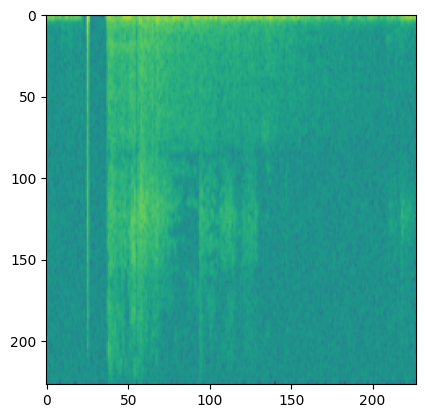

In [97]:
val = np.load('data/sound/800.npy')
val = data2fftimge(val)
plt.imshow(val)

In [98]:

# mix the data

np.random.shuffle(data)
obj_data = cDataLoader(data,1,shuffle=True)
train, test, validation = np.split(data, [int(len(data)*0.7),int(len(data)*0.8)])
obj_train = cDataLoader(train,shuffle=True)
obj_val = cDataLoader(validation,shuffle=True)
obj_test = cDataLoader(test,shuffle=True)

print(len(train),len(validation),len(test))

630 180 90


(1, 227, 227, 3)


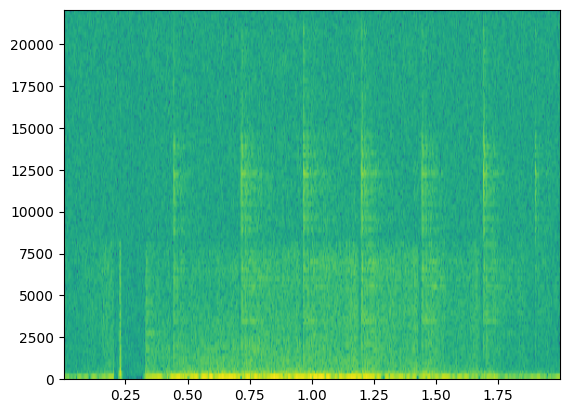

In [99]:
print(obj_data[1][0].shape)

### MODEL

In [103]:
# Hyper-parameters
epochs = 3000
learning_rate = 0.01
batch_size = 128
optimizer = k.optimizers.Adam(learning_rate=learning_rate)

# sample_size = obj_data[1][0].shape
# data_in = k.Input(shape =(sample_size[1],sample_size[2],sample_size[3]), name= "data_input")
#
# val = k.layers.Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),activation="relu",name="conv_1")(data_in)
#
# val = k.layers.BatchNormalization()(val)
#
# val = k.layers.MaxPool2D(pool_size=(3,3),strides=(2,2),name="pool_1")(val)
#
# val = k.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),activation="relu",name="conv_2",padding='same')(val)
#
# val = k.layers.BatchNormalization()(val)
#
# val = k.layers.MaxPool2D(pool_size=(3,3),strides=(2,2), name="pool_2")(val)
#
# val = k.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation="relu",name="conv_4",padding='same')(val)
#
# val = k.layers.BatchNormalization()(val)
#
# val = k.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),activation="relu",name="conv_5",padding='same')(val)
#
# val = k.layers.BatchNormalization()(val)
#
# val = k.layers.MaxPool2D(pool_size=(3,3),strides=(2,2), name="pool_3")(val)
#
# val = k.layers.Flatten()(val)
#
# val = k.layers.Dense(4096,activation='relu')(val)
#
# val = k.layers.Dropout(0.5)(val)
#
# val = k.layers.Dense(4096,activation='relu')(val)
#
# val = k.layers.Dropout(0.5)(val)
#
# out = k.layers.Dense(units=3, name="out",activation='softmax')(val)
#
# model1 = k.Model(inputs=data_in,outputs=out)
# model1.compile(optimizer=optimizer,loss=k.losses.categorical_crossentropy,metrics=['accuracy'])

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(sample_size[1],sample_size[2],sample_size[3])))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

early_stopping = k.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 114, 114, 32)      896       
                                                                 
 batch_normalization_16 (Bat  (None, 114, 114, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 57, 32)       0         
 )                                                               
                                                                 
 batch_normalization_17 (Bat  (None, 57, 57, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                        

Epoch 1/3000
79/79 [==============================] - 84s 1s/step - loss: 1059.7423 - accuracy: 0.6349 - val_loss: 4797.0786 - val_accuracy: 0.2833
Epoch 2/3000
79/79 [==============================] - 91s 1s/step - loss: 299.0698 - accuracy: 0.6143 - val_loss: 139.5614 - val_accuracy: 0.6667
Epoch 3/3000
79/79 [==============================] - 83s 1s/step - loss: 127.7347 - accuracy: 0.6667 - val_loss: 44.5323 - val_accuracy: 0.6778
Epoch 4/3000
79/79 [==============================] - 85s 1s/step - loss: 89.7001 - accuracy: 0.7429 - val_loss: 447.6496 - val_accuracy: 0.5778
Epoch 5/3000
64/79 [=======================>......] - ETA: 14s - loss: 112.1542 - accuracy: 0.8398

KeyboardInterrupt: 

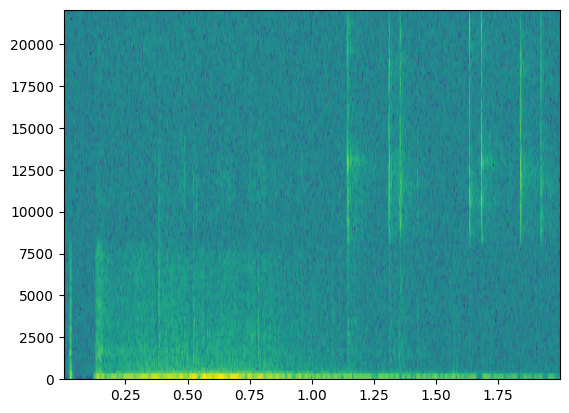

In [102]:
hist = model.fit(x=obj_train,batch_size=batch_size, epochs=epochs, shuffle=True, validation_data=obj_val, callbacks=[early_stopping])
#Validation loss and training loss graphs
plt.plot(hist.history['loss'], c='b')
plt.plot(hist.history['val_loss'], c='r')
plt.show()
plt.plot(hist.history['accuracy'], c='b')
plt.plot(hist.history['val_accuracy'], c='r')

# DEMO HW
- use data loader and construct DNN for image classifcication
- track the acc, f1 score based on your input data, use augmenation if needed
- on the final demo, the results(confustion matrix) needed to be show, with real time data
- f1 score >= 80
- resnet